In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import regex as re
import nltk
from nltk.corpus import stopwords
import numpy as np
from tensorflow.keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.layers.core import Dense, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import save_model, load_model

from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import math, time
import tensorflow as tf
from scipy.special import softmax

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ModuleNotFoundError: No module named 'keras.layers.embeddings'

In [2]:
data = pd.read_csv('/kaggle/input/queries/queries.csv')

In [3]:
data

,queries,files
0,minimum-focusing-distance 0.49-m,CameraLens
1,maximum-magnification-(x),CameraLens
2,maximum-focal-length,CameraLens
3,lens-cap snap-on,CameraLens
4,black,CameraLens
...,...,...
22152,model-number itemmart-m4-black model-number sw...,WearableSmartDevice
22153,model-number itemmart-m4-black model-number sw...,WearableSmartDevice
22154,model-number itemmart-m4-black model-number sw...,WearableSmartDevice
22155,model-number itemmart-m4-black model-number sw...,WearableSmartDevice


In [4]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #.+_-]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    text = re.sub('-',' ',text)
    return text

data['queries'] = data['queries'].apply(clean_text)

In [5]:
data

,queries,files
0,minimum focusing distance 0.49 m,CameraLens
1,maximum magnification x,CameraLens
2,maximum focal length,CameraLens
3,lens cap snap on,CameraLens
4,black,CameraLens
...,...,...
22152,model number itemmart m4 black model number sw...,WearableSmartDevice
22153,model number itemmart m4 black model number sw...,WearableSmartDevice
22154,model number itemmart m4 black model number sw...,WearableSmartDevice
22155,model number itemmart m4 black model number sw...,WearableSmartDevice


In [6]:
filename = ['CameraLens', 'Laptop', 'LaptopPeriferals', 'Mobile','Refrigerator', 'Tablet', 'TV', 'WashingMachine','WearableSmartDevice']

In [7]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 32
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['queries'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3111 unique tokens.


In [8]:
X = tokenizer.texts_to_sequences(data['queries'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (22157, 32)


In [9]:
Y = pd.get_dummies(data['files']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (22157, 9)


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(17725, 32) (17725, 9)
(4432, 32) (4432, 9)


In [11]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

2022-12-21 19:49:47.941145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 19:49:47.942254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 19:49:47.942924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 19:49:47.943770: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/5
250/250 [==============================] - 39s 145ms/step - loss: 0.6454 - accuracy: 0.8091 - val_loss: 0.2840 - val_accuracy: 0.9064
Epoch 2/5
250/250 [==============================] - 36s 145ms/step - loss: 0.2346 - accuracy: 0.9224 - val_loss: 0.2155 - val_accuracy: 0.9210
Epoch 3/5
250/250 [==============================] - 36s 145ms/step - loss: 0.1604 - accuracy: 0.9479 - val_loss: 0.1806 - val_accuracy: 0.9340
Epoch 4/5
250/250 [==============================] - 36s 143ms/step - loss: 0.1167 - accuracy: 0.9635 - val_loss: 0.1800 - val_accuracy: 0.9340
Epoch 5/5
250/250 [==============================] - 36s 143ms/step - loss: 0.0863 - accuracy: 0.9715 - val_loss: 0.1934 - val_accuracy: 0.9329


In [12]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

139/139 [==============================] - 1s 9ms/step - loss: 0.1844 - accuracy: 0.9361
Test set
  Loss: 0.184
  Accuracy: 0.936


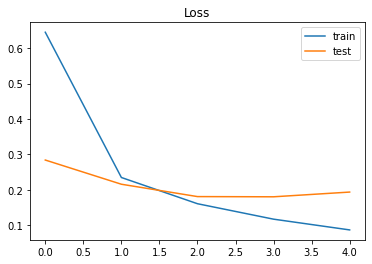

In [13]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

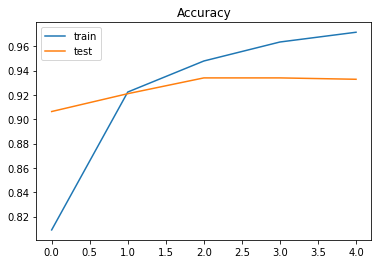

In [14]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [15]:
sample_query = ['minimum focusing distance 0.49 m','lens cap snap on']
for query in sample_query:
    X_sample = tokenizer.texts_to_sequences([query])
    X_sample = pad_sequences(X_sample, maxlen=MAX_SEQUENCE_LENGTH)
    print(len(X_sample))

1
1


In [16]:
len(X_sample)

1

In [17]:
X_sample

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 104, 118, 133, 120]], dtype=int32)

In [18]:
predict_x=model.predict(X_sample)
print(predict_x)

[[9.9960965e-01 2.0314235e-04 4.4864828e-05 1.6148826e-05 3.3672181e-06
  1.8934652e-05 1.6990532e-05 4.7774938e-05 3.9112991e-05]]


In [19]:
predict_x

array([[9.9960965e-01, 2.0314235e-04, 4.4864828e-05, 1.6148826e-05,
        3.3672181e-06, 1.8934652e-05, 1.6990532e-05, 4.7774938e-05,
        3.9112991e-05]], dtype=float32)

In [20]:
result = [val for (_, val) in sorted(zip(predict_x[0], filename), key=lambda x: x[0],reverse = True)]
print(result)

['CameraLens', 'Laptop', 'WashingMachine', 'LaptopPeriferals', 'WearableSmartDevice', 'Tablet', 'TV', 'Mobile', 'Refrigerator']


In [21]:
save_model(model,'/kaggle/working/query_model.model')

2022-12-21 19:53:01.631394: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [22]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)